In [1]:
import pathlib

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# load the training data
profile_file_dir = pathlib.Path("../data_splits/test.parquet").resolve(strict=True)

models_path = pathlib.Path("../models").resolve(strict=True)

terminal_column_names = pathlib.Path("../results/terminal_columns.txt").resolve(
    strict=True
)
predictions_save_path = pathlib.Path(
    "../results/predicted_terminal_profiles.parquet"
).resolve()
terminal_column_names = [
    line.strip() for line in terminal_column_names.read_text().splitlines()
]
results_dir = pathlib.Path("../results/").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

profile_df = pd.read_parquet(profile_file_dir)
print(profile_df.shape)
profile_df.head()

(10, 2918)


,Metadata_Well,Metadata_dose,Metadata_number_of_singlecells,Metadata_apoptosis_ground_truth,Metadata_plate,Metadata_compound,Metadata_control,Cells_AreaShape_Compactness_CP,Cells_AreaShape_Eccentricity_CP,Cells_AreaShape_Extent_CP,...,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_00_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_01_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_02_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_03_256,Terminal_Nuclei_Texture_Correlation_DNA_3_02_256,Terminal_Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_DNA_3_01_256,Terminal_Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Terminal_Nuclei_Texture_SumAverage_DNA_3_00_256
0,C-04,1.22,166.0,negative,1,Staurosporine,test,-0.239434,0.368518,0.282078,...,-0.837640,-0.648602,-0.839328,-0.665333,0.670119,-0.774637,-0.010179,0.521993,-0.121325,0.416877
1,C-06,4.88,134.0,negative,1,Staurosporine,test,-0.853027,-0.335576,0.908984,...,-0.594116,-0.648602,-0.601680,-0.665333,0.670119,-0.662763,0.175557,0.521993,-0.108781,0.416877
2,D-02,0.00,167.0,control,1,Staurosporine,negative,-0.154453,0.434519,-0.025407,...,-0.289916,-0.459840,-0.252233,-0.497146,0.670119,-0.183291,0.456748,0.521993,-0.086875,0.416877
3,D-03,0.61,184.0,negative,1,Staurosporine,test,-0.029311,0.460390,-0.086369,...,-0.803779,-0.648602,-0.745542,-0.665333,0.670119,-0.566059,0.188165,0.521993,-0.121325,0.416877
4,D-05,2.44,177.0,negative,1,Staurosporine,test,-0.447601,0.122046,0.366804,...,-0.649381,-0.648602,-0.659624,-0.665333,0.670119,-0.616048,0.233336,0.521993,-0.111544,0.416877


In [3]:
terminal_df = profile_df[terminal_column_names]
profile_df = profile_df.drop(columns=terminal_column_names)

In [4]:
models = pathlib.Path(models_path).glob("*.joblib")
models_dict = {
    "model_name": [],
    "model_path": [],
    "shuffled": [],
    "feature": [],
}

for model_path in models:
    print(model_path.name)
    # print(model_path.name.split("singlefeature")[1].strip(".joblib").strip("_"))
    models_dict["model_name"].append(model_path.name)
    models_dict["model_path"].append(model_path)
    models_dict["shuffled"].append(
        "shuffled" if "shuffled" in model_path.name else "not_shuffled"
    )
    models_dict["feature"].append(
        model_path.name.split("singlefeature")[1].strip(".joblib").strip("_")
        if "singlefeature" in model_path.name
        else "all_terminal_features"
    )

train_shuffled_elastic_net_model_singlefeature_Terminal_Cytoplasm_Intensity_MaxIntensity_AnnexinV.joblib
train_elastic_net_model_singlefeature_Terminal_Cytoplasm_Intensity_MaxIntensity_AnnexinV.joblib
train_elastic_net_model_singlefeature_Terminal_Cells_Intensity_MaxIntensityEdge_AnnexinV.joblib
train_shuffled_elastic_net_model_singlefeature_Terminal_Cells_Intensity_MaxIntensityEdge_AnnexinV.joblib
train_shuffled_elastic_net_model_all_terminal_features.joblib
train_elastic_net_model_all_terminal_features.joblib


In [5]:
def model_stats_grab(
    predicted_df: pd.DataFrame,
    actual_df: pd.DataFrame,
) -> tuple:
    """
    Calculate model statistics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2) from predicted and actual values.

        Parameters
        ----------
        predicted_df : pd.DataFrame
            DataFrame containing the predicted values.
        actual_df : pd.DataFrame
            DataFrame containing the actual values.

        Returns
        -------
        tuple
        mse : float
            Mean Squared Error between predicted and actual values.
        mae : float
            Mean Absolute Error between predicted and actual values.
        r2 : float
            R-squared value indicating the proportion of variance explained by the model.
    """

    assert (
        predicted_df.shape == actual_df.shape
    ), "Predicted and actual DataFrames must have the same shape."
    # if predicted_df.isinstance(pd.DataFrame):
    #     predicted = predicted_df.values
    # if isinstance(predicted_df, pd.Series):
    #     actual = actual_df.values

    mse = mean_squared_error(actual_df, predicted_df)
    mae = mean_absolute_error(actual_df, predicted_df)
    r2 = r2_score(actual_df, predicted_df)

    return mse, mae, r2

In [6]:
results_dict = {
    "model_name": [],
    "shuffled": [],
    "feature": [],
    "mse": [],
    "mae": [],
    "r2": [],
}

In [7]:
metadata_columns = [x for x in profile_df.columns if "metadata" in x.lower()]
features_df = profile_df.drop(columns=metadata_columns, errors="ignore")

In [8]:
for i, model_name in enumerate(models_dict["model_name"]):
    print(f"Processing model {i + 1}/{len(models_dict['model_name'])}: {model_name}")
    model = joblib.load(models_dict["model_path"][i])
    if models_dict["feature"][i] != "all_terminal_features":
        predictions = model.predict(features_df)
        mse, mae, r2 = model_stats_grab(
            predictions, terminal_df[models_dict["feature"][i]]
        )
        results_dict["shuffled"].append(models_dict["shuffled"][i])
        results_dict["feature"].append(models_dict["feature"][i])
    else:
        predictions = model.predict(features_df)
        mse, mae, r2 = model_stats_grab(predictions, terminal_df)
        results_dict["shuffled"].append(models_dict["shuffled"][i])
        results_dict["feature"].append("all_terminal_features")

    results_dict["model_name"].append(model_name)
    results_dict["mse"].append(mse)
    results_dict["mae"].append(mae)
    results_dict["r2"].append(r2)
results_df = pd.DataFrame(results_dict)
results_df.head(8)

Processing model 1/6: train_shuffled_elastic_net_model_singlefeature_Terminal_Cytoplasm_Intensity_MaxIntensity_AnnexinV.joblib
Processing model 2/6: train_elastic_net_model_singlefeature_Terminal_Cytoplasm_Intensity_MaxIntensity_AnnexinV.joblib
Processing model 3/6: train_elastic_net_model_singlefeature_Terminal_Cells_Intensity_MaxIntensityEdge_AnnexinV.joblib
Processing model 4/6: train_shuffled_elastic_net_model_singlefeature_Terminal_Cells_Intensity_MaxIntensityEdge_AnnexinV.joblib
Processing model 5/6: train_shuffled_elastic_net_model_all_terminal_features.joblib
Processing model 6/6: train_elastic_net_model_all_terminal_features.joblib


,model_name,shuffled,feature,mse,mae,r2
0,train_shuffled_elastic_net_model_singlefeature...,shuffled,Terminal_Cytoplasm_Intensity_MaxIntensity_Anne...,0.099041,0.243526,-5.328798
1,train_elastic_net_model_singlefeature_Terminal...,not_shuffled,Terminal_Cytoplasm_Intensity_MaxIntensity_Anne...,0.020310,0.109819,-0.297849
2,train_elastic_net_model_singlefeature_Terminal...,not_shuffled,Terminal_Cells_Intensity_MaxIntensityEdge_Anne...,0.005884,0.064278,0.598207
3,train_shuffled_elastic_net_model_singlefeature...,shuffled,Terminal_Cells_Intensity_MaxIntensityEdge_Anne...,0.015633,0.100143,-0.067445
4,train_shuffled_elastic_net_model_all_terminal_...,shuffled,all_terminal_features,0.126193,0.217727,-0.254646
5,train_elastic_net_model_all_terminal_features....,not_shuffled,all_terminal_features,0.044425,0.136030,0.067443


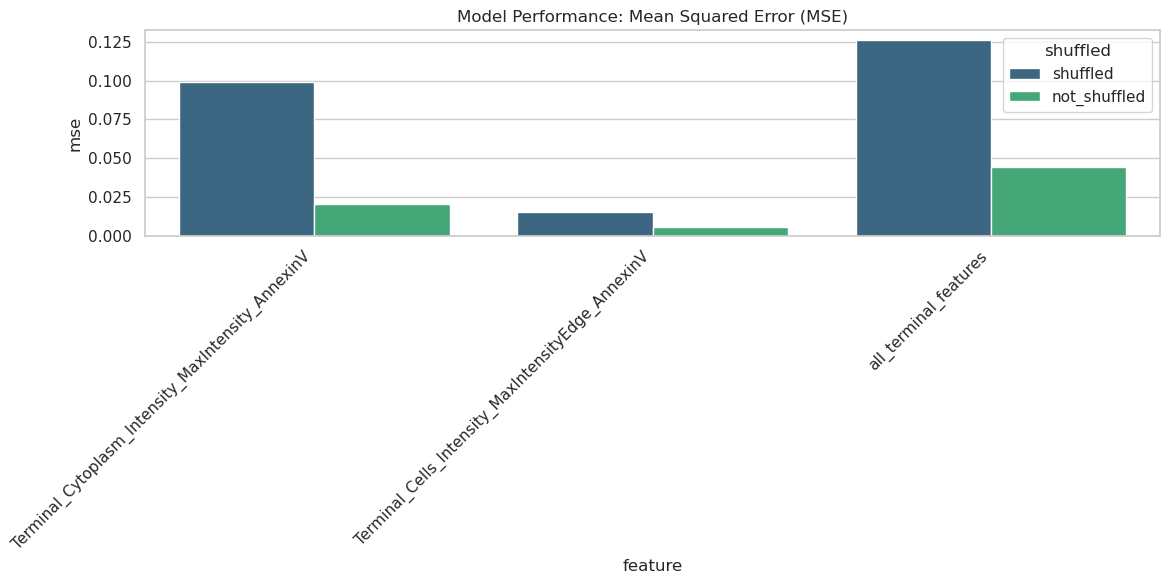

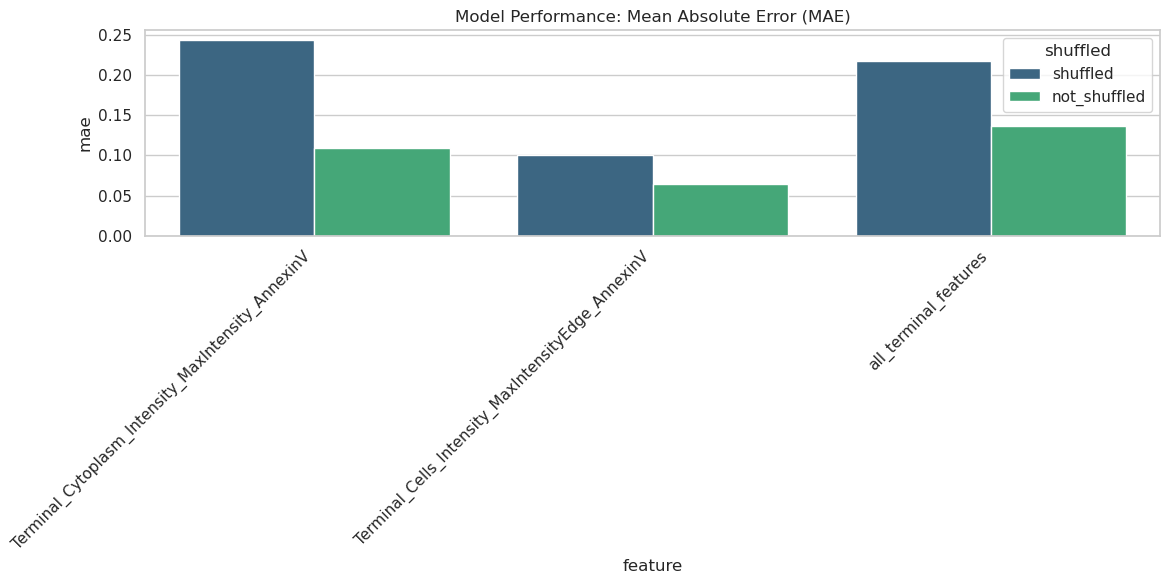

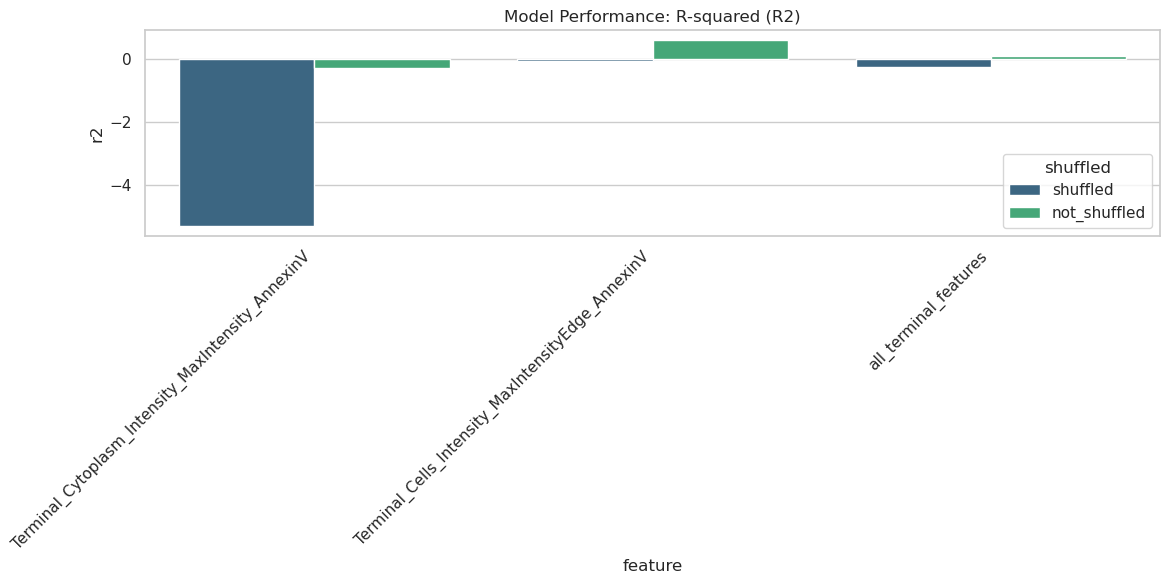

In [9]:
# plot the performance of the models
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="feature", y="mse", hue="shuffled", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Performance: Mean Squared Error (MSE)")
plt.tight_layout()
# plt.savefig(results_dir / "model_performance_mse.png")
plt.figure(figsize=(12, 6))
sns.barplot(x="feature", y="mae", hue="shuffled", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Performance: Mean Absolute Error (MAE)")
plt.tight_layout()
# plt.savefig(results_dir / "model_performance_mae.png")
plt.figure(figsize=(12, 6))
sns.barplot(x="feature", y="r2", hue="shuffled", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Performance: R-squared (R2)")
plt.tight_layout()
# plt.savefig(results_dir / "model_performance_r2.png")
# Save the results DataFrame to a parquet file
# results_df.to_parquet(predictions_save_path, index=False)